# Utility functions

In [36]:
import os
from math import sqrt
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt
import sys
sys.path.append(os.path.join(os.getcwd(), 'common'))
import utility
import random
import pywt
from skimage.transform import rescale

In [37]:
def wpsnr(img1, img2):
    img1 = np.float32(img1)/255.0
    img2 = np.float32(img2)/255.0
    difference = img1-img2
    same = not np.any(difference)
    if same is True:
        return 9999999
    w = np.genfromtxt('csf.csv', delimiter=',')
    ew = convolve2d(difference, np.rot90(w,2), mode='valid')
    decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
    return decibels

## Edges detection

In [38]:
def sobel_edges(img):
  sobelimage=img.copy()
  sobelx = cv2.Sobel(sobelimage,cv2.CV_64F,1,0,ksize=3)
  sobely = cv2.Sobel(sobelimage,cv2.CV_64F,0,1,ksize=3)
  magnitude = np.sqrt(sobelx**2 + sobely**2)
  magnitude = cv2.convertScaleAbs(magnitude)
  _, thresholded = cv2.threshold(magnitude, 100, 255, cv2.THRESH_BINARY)
  return thresholded
  
def canny_edges(img):
  th1=30
  th2=60
  d=2
  edgeresult=img.copy()
  edgeresult = cv2.GaussianBlur(edgeresult, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
  edgeresult = edgeresult.astype(np.uint8)
  edges = cv2.Canny(edgeresult, th1, th2)
  return edges

## Basic attack functions

In [57]:
def blur(img, sigma):
  attacked = gaussian_filter(img, sigma)
  return attacked

def median(img, sigma):
  attacked = medfilt(img, sigma)
  return attacked

def awgn(img, std, seed):
  mean = 0.0
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

def jpeg_compression(img, qf):
  img = Image.fromarray(img)
  img.save('tmp.jpg',"JPEG", quality=qf)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')
  return attacked

def resizing(img, scale):
  x, y = img.shape
  attacked = rescale(img, scale, anti_aliasing=True, mode='reflect')
  attacked = rescale(attacked, 1/scale, anti_aliasing=True, mode='reflect')
  attacked = np.asarray(attacked * 255, dtype=np.uint8)
  attacked = cv2.resize(attacked, (y, x), interpolation=cv2.INTER_LINEAR)
  return attacked

# Edge-preserving blur

In [89]:
def edge_preserving_blur(img, sigma, edge_func, blur_func):
  edges = edge_func(img)
  if edges.max() > 0:
    edges = edges / edges.max()
  edges = cv2.resize(edges, (img.shape[1], img.shape[0]))
  blurred_img = blur_func(img, sigma)
  attacked = edges * img + (1 - edges) * blurred_img
  return (attacked, 'Edge-preserving blur', '')

# AWGN on edges

In [41]:
def edge_awgn(img, std, seed, edge_func):
    attacked = img.copy()
    edges_results = img.copy()
    global_awgn = awgn(img, std, seed)
    edges = edge_func(img)
    edges = edges / edges.max()
    edges = cv2.resize(edges, (img.shape[1], img.shape[0]))
    edges_results[edges > 0] = [255]
    attacked[edges > 0] = global_awgn[edges > 0] 
    return (attacked, 'Awgn on edges', '')

# Blur on DWT

In [42]:
def blur_dwt(img, edge_func, blur_func, sigma, awgn, std, seed, edge_func_awgn):
    coeffs2 = pywt.dwt2(img, 'haar')
    LL, (LH, HL, HH) = coeffs2
    
    if edge_func == None:
        LH_blurred = blur_func(LH, sigma)
        HL_blurred = blur_func(HL, sigma)
        HH_blurred = blur_func(HH, sigma)
    else:
        LH_blurred = edge_preserving_blur(LH, sigma, edge_func, blur_func)[0]
        HL_blurred = edge_preserving_blur(HL, sigma, edge_func, blur_func)[0]
        HH_blurred = edge_preserving_blur(HH, sigma, edge_func, blur_func)[0]
        
    if awgn == 1:
        LH_blurred = edge_awgn(LH_blurred, std, seed, edge_func_awgn)[0]
        HL_blurred = edge_awgn(HL_blurred, std, seed, edge_func_awgn)[0]
        HH_blurred = edge_awgn(HH_blurred, std, seed, edge_func_awgn)[0]
    
    coeffs2_blurred = (LL, (LH_blurred, HL_blurred, HH_blurred))
    reconstructed_image = pywt.idwt2(coeffs2_blurred, 'haar')
    reconstructed_image = np.clip(reconstructed_image, 0, 255)
    return (reconstructed_image.astype(np.uint8),'Blur on dwt','')

# Plot images and check wpsnr

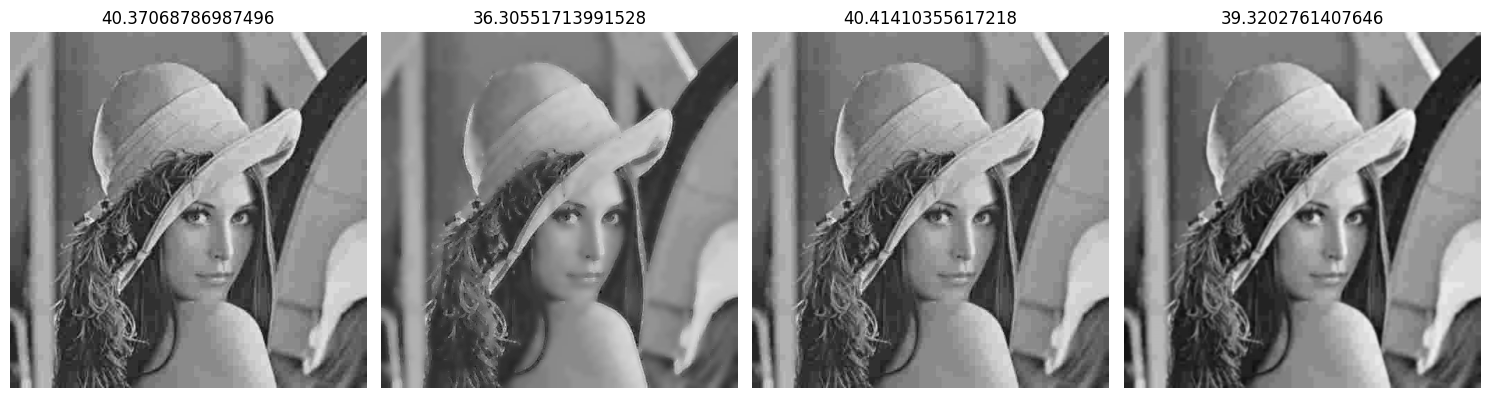

In [91]:
original = cv2.imread('lena_grey.bmp', 0)

attack1 = jpeg_compression(original, 10)
attack2 = edge_preserving_blur(attack1.copy(), [3,3], sobel_edges, blur)[0]
attack3 = blur_dwt(attack1.copy(), sobel_edges, median, [7,7], 0, None, None, None)[0]
attack4 = resizing(attack1.copy(), 0.5)

utility.visualize_images_with_desc([attack1, attack2, attack3, attack4],[str(wpsnr(original, attack1)), str(wpsnr(original, attack2)), str(wpsnr(original, attack3)), str(wpsnr(original, attack4))])

# Possible attacks

In [44]:
attack_list = [
    lambda img: edge_preserving_blur(img, [3,3], sobel_edges, blur),
    lambda img: edge_preserving_blur(img, [3,3], sobel_edges, median),
    lambda img: edge_preserving_blur(img, [3,3], canny_edges, blur),
    lambda img: edge_preserving_blur(img, [3,3], canny_edges, median),
    
    lambda img: edge_awgn(img, random.randint(10,100), random.randint(10,100), sobel_edges),
    lambda img: edge_awgn(img, random.randint(10,100), random.randint(10,100), canny_edges),
    
    lambda img: edge_awgn(edge_preserving_blur(img, [3,3], sobel_edges, blur)[0], random.randint(10,100), random.randint(10,100), sobel_edges),
    lambda img: edge_awgn(edge_preserving_blur(img, [3,3], sobel_edges, median)[0], random.randint(10,100), random.randint(10,100), sobel_edges),
    lambda img: edge_awgn(edge_preserving_blur(img, [3,3], canny_edges, blur)[0], random.randint(10,100), random.randint(10,100), sobel_edges),
    lambda img: edge_awgn(edge_preserving_blur(img, [3,3], canny_edges, median)[0], random.randint(10,100), random.randint(10,100), sobel_edges),
    lambda img: edge_awgn(edge_preserving_blur(img, [3,3], sobel_edges, blur)[0], random.randint(10,100), random.randint(10,100), canny_edges),
    lambda img: edge_awgn(edge_preserving_blur(img, [3,3], sobel_edges, median)[0], random.randint(10,100), random.randint(10,100), canny_edges),
    lambda img: edge_awgn(edge_preserving_blur(img, [3,3], canny_edges, blur)[0], random.randint(10,100), random.randint(10,100), canny_edges),
    lambda img: edge_awgn(edge_preserving_blur(img, [3,3], canny_edges, median)[0], random.randint(10,100), random.randint(10,100), canny_edges),
    
    lambda img: blur_dwt(img, None, blur, [3,3], 0, None, None, None)[0],
    lambda img: blur_dwt(img, None, median, [3,3], 0, None, None, None)[0],
    lambda img: blur_dwt(img, sobel_edges, blur, [3,3], 0, None, None, None)[0],
    lambda img: blur_dwt(img, canny_edges, blur, [3,3], 0, None, None, None)[0],
    lambda img: blur_dwt(img, sobel_edges, median, [3,3], 0, None, None, None)[0],
    lambda img: blur_dwt(img, canny_edges, median, [3,3], 0, None, None, None)[0],
    lambda img: blur_dwt(img, None, blur, [3,3], 1, random.randint(10,100), random.randint(10,100), sobel_edges)[0],
    lambda img: blur_dwt(img, None, median, [3,3], 1, random.randint(10,100), random.randint(10,100), sobel_edges)[0],
    lambda img: blur_dwt(img, sobel_edges, blur, [3,3], 1, random.randint(10,100), random.randint(10,100), sobel_edges)[0],
    lambda img: blur_dwt(img, canny_edges, blur, [3,3], 1, random.randint(10,100), random.randint(10,100), sobel_edges)[0],
    lambda img: blur_dwt(img, sobel_edges, median, [3,3], 1, random.randint(10,100), random.randint(10,100), sobel_edges)[0],
    lambda img: blur_dwt(img, canny_edges, median, [3,3], 1, random.randint(10,100), random.randint(10,100), sobel_edges)[0],
    lambda img: blur_dwt(img, None, blur, [3,3], 1, random.randint(10,100), random.randint(10,100), canny_edges)[0],
    lambda img: blur_dwt(img, None, median, [3,3], 1, random.randint(10,100), random.randint(10,100), canny_edges)[0],
    lambda img: blur_dwt(img, sobel_edges, blur, [3,3], 1, random.randint(10,100), random.randint(10,100), canny_edges)[0],
    lambda img: blur_dwt(img, canny_edges, blur, [3,3], 1, random.randint(10,100), random.randint(10,100), canny_edges)[0],
    lambda img: blur_dwt(img, sobel_edges, median, [3,3], 1, random.randint(10,100), random.randint(10,100), canny_edges)[0],
    lambda img: blur_dwt(img, canny_edges, median, [3,3], 1, random.randint(10,100), random.randint(10,100), canny_edges)[0]
]